In [1]:
#To hide warnings export PYTHONWARNINGS="ignore"
#Imports{

import os
from os.path import dirname
from os.path import join
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Cha


import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import cPickle as pickle
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.misc import imread
from scipy.misc import imresize
from scipy.io import loadmat
from scipy.interpolate import spline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D, Input, ZeroPadding2D,merge,Lambda
from keras.layers.convolutional import Convolution2D
from keras.models import Model
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.optimizers import SGD
from keras import backend as K
from keras.engine import Layer
from keras.layers.core import Lambda
from keras.utils.vis_utils import plot_model
from keras.layers.core import  Lambda
from keras.regularizers import l2
#}

Using Theano backend.


In [2]:
#Code snippet needed to read activation values from each layer of the pre-trained artificial neural networks
def get_activations(model, layer, X_batch):
    #keras.backend.function(inputs, outputs, updates=None)
    get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.layers[layer].output,])
    #The learning phase flag is a bool tensor (0 = test, 1 = train)
    activations = get_activations([X_batch,0])
    return activations

In [3]:
#Function to pre-process the input image to ensure uniform size and color
def preprocess_image_batch(image_paths, img_size=None, crop_size=None, color_mode='rgb', out=None):
    """
    Consistent preprocessing of images batches
    :param image_paths: iterable: images to process
    :param crop_size: tuple: crop images if specified
    :param img_size: tuple: resize images if specified
    :param color_mode: Use rgb or change to bgr mode based on type of model you want to use
    :param out: append output to this iterable if specified
    """
    img_list = []

    for im_path in image_paths:
        img = imread(im_path, mode='RGB')
        #print im_path
        #print img.shape
        if img_size:
            img = imresize(img, img_size)

        img = img.astype('float32')
        # We normalize the colors (in RGB space) with the empirical means on the training set
        img[:, :, 0] -= 123.68
        img[:, :, 1] -= 116.779
        img[:, :, 2] -= 103.939
        # We permute the colors to get them in the BGR order
        if color_mode == 'bgr':
            img[:, :, [0, 1, 2]] = img[:, :, [2, 1, 0]]
        img = img.transpose((2, 0, 1))

        if crop_size:
            img = img[:, (img_size[0] - crop_size[0]) // 2:(img_size[0] + crop_size[0]) // 2
            , (img_size[1] - crop_size[1]) // 2:(img_size[1] + crop_size[1]) // 2]

        img_list.append(img)

    try:
        img_batch = np.stack(img_list, axis=0)
    except:
        print im_path
        raise ValueError('when img_size and crop_size are None, images'
                ' in image_paths must have the same shapes.')

    if out is not None and hasattr(out, 'append'):
        out.append(img_batch)
    else:
        return img_batch

In [4]:
#Helper function to normalization across channels
K.set_image_dim_ordering('th')
def crosschannelnormalization(alpha=1e-4, k=2, beta=0.75, n=5, **kwargs):
    """
    This is the function used for cross channel normalization in the original
    Alexnet
    """
    def f(X):
        if K.image_dim_ordering()=='tf':
            b, r, c, ch = X.get_shape()
        else:
            b, ch, r, c = X.shape

        half = n // 2
        square = K.square(X)
        scale = k
        if K.image_dim_ordering() == 'th':
            extra_channels = K.spatial_2d_padding(K.permute_dimensions(square, (0, 2, 3, 1)), ((0,0),(half,half)))
            extra_channels = K.permute_dimensions(extra_channels, (0, 3, 1, 2))
            for i in range(n):
                scale += alpha * extra_channels[:, i:i+ch, :, :]
        if K.image_dim_ordering() == 'tf':
            extra_channels = K.spatial_2d_padding(K.permute_dimensions(square, (0, 3, 1, 2)), (half, 0))
            extra_channels = K.permute_dimensions(extra_channels, (0, 2, 3, 1))
            for i in range(n):
                scale += alpha * extra_channels[:, :, :, i:i+int(ch)]
        scale = scale ** beta
        return X / scale


    return Lambda(f, output_shape=lambda input_shape: input_shape, **kwargs)

In [5]:
#Helper Function to split tensor
def splittensor(axis=1, ratio_split=1, id_split=0, **kwargs):
    def f(X):
        div = K.shape(X)[axis] // ratio_split

        if axis == 0:
            output = X[id_split*div:(id_split+1)*div, :, :, :]
        elif axis == 1:
            output = X[:, id_split*div:(id_split+1)*div, :, :]
        elif axis == 2:
            output = X[:, :, id_split*div:(id_split+1)*div, :]
        elif axis == 3:
            output = X[:, :, :, id_split*div:(id_split+1)*div]
        else:
            raise ValueError("This axis is not possible")
        return output

    def g(input_shape):
        output_shape = list(input_shape)
        output_shape[axis] = output_shape[axis] // ratio_split
        return tuple(output_shape)


    return Lambda(f, output_shape=lambda input_shape: g(input_shape), **kwargs)

In [6]:
#Alexnet layer architecture class
def AlexNet(img_shape=(3, 227, 227), n_classes=1000, l2_reg=0.,weights_path=None, lambda_mask=None):

    dim_ordering = K.image_dim_ordering()
    print dim_ordering
    if dim_ordering == 'th':
        batch_index = 0
        channel_index = 1
        row_index = 2
        col_index = 3
    if dim_ordering == 'tf':
        batch_index = 0
        channel_index = 3
        row_index = 1
        col_index = 2
        
    
    inputs = Input(img_shape)

    conv_1 = Convolution2D(96, 11, 11, subsample=(4, 4), activation='relu',
                           name='conv_1', W_regularizer=l2(l2_reg))(inputs)

    if lambda_mask is not None:
        conv_1_mask  = np.reshape(lambda_mask[0:290400], (96,55,55))
    else:
        conv_1_mask = np.ones(shape=((96, 55, 55)))
    
    conv_1_mask  = K.variable(conv_1_mask)
    conv_1_lambda = Lambda(lambda x: x * conv_1_mask)(conv_1)

    conv_2 = MaxPooling2D((3, 3), strides=(2, 2))(conv_1_lambda)
    conv_2 = crosschannelnormalization(name="convpool_1")(conv_2)
    conv_2 = ZeroPadding2D((2, 2))(conv_2)
    conv_2 = merge([
        Convolution2D(128, 5, 5, activation="relu", name='conv_2_'+str(i+1),
                      W_regularizer=l2(l2_reg))(
            splittensor(axis=channel_index, ratio_split=2, id_split=i)(conv_2)
        ) for i in range(2)], mode='concat', concat_axis=channel_index, name="conv_2")

    if lambda_mask is not None:
        conv_2_mask  = np.reshape(lambda_mask[290400:477024],(256, 27, 27) )
    else:
        conv_2_mask = np.ones(shape=((256, 27, 27)))
        
    conv_2_mask = K.variable(conv_2_mask)
    conv_2_lambda = Lambda(lambda x: x * conv_2_mask)(conv_2)

    conv_3 = MaxPooling2D((3, 3), strides=(2, 2))(conv_2_lambda)
    conv_3 = crosschannelnormalization()(conv_3)
    conv_3 = ZeroPadding2D((1, 1))(conv_3)
    conv_3 = Convolution2D(384, 3, 3, activation='relu', name='conv_3',
                           W_regularizer=l2(l2_reg))(conv_3)

    if lambda_mask is not None:
        conv_3_mask  = np.reshape(lambda_mask[477024:541920],(384, 13, 13))
    else:
        conv_3_mask = np.ones(shape=((384, 13, 13)))
    
    conv_3_mask = K.variable(conv_3_mask)
    conv_3_lambda = Lambda(lambda x: x * conv_3_mask)(conv_3)

    conv_4 = ZeroPadding2D((1, 1))(conv_3_lambda)
    conv_4 = merge([
        Convolution2D(192, 3, 3, activation="relu", name='conv_4_'+str(i+1),
                      W_regularizer=l2(l2_reg))(
            splittensor(axis=channel_index, ratio_split=2, id_split=i)(conv_4)
        ) for i in range(2)], mode='concat', concat_axis=channel_index, name="conv_4")

    if lambda_mask is not None:
        conv_4_mask  = np.reshape(lambda_mask[541920:606816],(384, 13, 13))
    else:
        conv_4_mask = np.ones(shape=((384, 13, 13)))
        
    conv_4_mask = K.variable(conv_4_mask)
    conv_4_lambda = Lambda(lambda x: x * conv_4_mask)(conv_4)

    conv_5 = ZeroPadding2D((1, 1))(conv_4_lambda)
    conv_5 = merge([
        Convolution2D(128, 3, 3, activation="relu", name='conv_5_'+str(i+1),
                      W_regularizer=l2(l2_reg))(
            splittensor(axis=channel_index, ratio_split=2, id_split=i)(conv_5)
        ) for i in range(2)], mode='concat', concat_axis=channel_index, name="conv_5")

    if lambda_mask is not None:
        conv_5_mask  = np.reshape(lambda_mask[606816:650080],(256, 13, 13))
    else:
        conv_5_mask = np.ones(shape=((256, 13, 13)))
    
    conv_5_mask = K.variable(conv_5_mask)
    conv_5_lambda = Lambda(lambda x: x * conv_5_mask)(conv_5)

    dense_1 = MaxPooling2D((3, 3), strides=(2, 2), name="convpool_5")(conv_5_lambda)

    dense_1 = Flatten(name="flatten")(dense_1)
    dense_1 = Dense(4096, activation='relu', name='dense_1',
                    W_regularizer=l2(l2_reg))(dense_1)

    if lambda_mask is not None:
        dense_1_mask  = np.reshape(lambda_mask[650080:654176],(4096,))
    else:
        dense_1_mask = np.ones(shape=((4096,)))
    
    
    dense_1_mask = K.variable(dense_1_mask)
    dense_1_lambda = Lambda(lambda x: x * dense_1_mask)(dense_1)

    dense_2 = Dropout(0.5)(dense_1_lambda)
    dense_2 = Dense(4096, activation='relu', name='dense_2',
                    W_regularizer=l2(l2_reg))(dense_2)

    if lambda_mask is not None:
        dense_2_mask  = np.reshape(lambda_mask[654176:658272],(4096,))
    else:
        dense_2_mask = np.ones(shape=((4096,)))
    
    dense_2_mask = K.variable(dense_2_mask)
    dense_2_lambda = Lambda(lambda x: x * dense_2_mask)(dense_2)

    dense_3 = Dropout(0.5)(dense_2_lambda)
    if n_classes == 1000:
        dense_3 = Dense(n_classes, name='dense_3',
                        W_regularizer=l2(l2_reg))(dense_3)
        if lambda_mask is not None:
            dense_3_mask  = np.reshape(lambda_mask[658272:659272],(1000,))
        else:
            dense_3_mask = np.ones(shape=((1000,)))
        dense_3_mask = K.variable(dense_3_mask)
        dense_3_lambda = Lambda(lambda x: x * dense_3_mask)(dense_3)
    else:
        # We change the name so when loading the weights_file from a
        # Imagenet pretrained model does not crash
        dense_3 = Dense(n_classes, name='dense_3_new',
                        W_regularizer=l2(l2_reg))(dense_3)
        if lambda_mask is not None:
            dense_3_mask  = np.reshape(lambda_mask[658272:659272],(1000,))
        else:
            dense_3_mask = np.ones(shape=((1000,)))
        dense_3_mask = K.variable(dense_3_mask)
        dense_3_lambda = Lambda(lambda x: x * dense_3_mask)(dense_3)

    prediction = Activation("softmax", name="softmax")(dense_3_lambda)

    model = Model(input=inputs, output=prediction)
    if weights_path:
        model.load_weights(weights_path)

    return model

In [7]:
#Load the details of all the 1000 classes and the function to conver the synset id to words{
meta_clsloc_file = '../../data/meta_clsloc.mat'
synsets = loadmat(meta_clsloc_file)['synsets'][0]
synsets_imagenet_sorted = sorted([(int(s[0]), str(s[1][0])) for s in synsets[:1000]],key=lambda v: v[1])
corr = {}
for j in range(1000):
    corr[synsets_imagenet_sorted[j][0]] = j

corr_inv = {}
for j in range(1, 1001):
    corr_inv[corr[j]] = j

def id_to_words(id_):
    return synsets[corr_inv[id_] - 1][2][0]

def pprint_output(out, n_max_synsets=10):
    wids = []
    best_ids = out.argsort()[::-1][:10]
    for u in best_ids:
        wids.append(str(synsets[corr_inv[u] - 1][1][0]))
    #print('%.2f' % round(100 * out[u], 2) + ' : ' + id_to_words(u)+' '+ str(synsets[corr_inv[u] - 1][1][0]))
    return wids


In [8]:
#Code snippet to load the ground truth labels to measure the performance{
truth = {}
with open('../../data/ILSVRC2014_clsloc_validation_ground_truth.txt') as f:
    line_num = 1
    for line in f.readlines():
        ind_ = int(line)
        temp  = None
        for i in synsets_imagenet_sorted:
            if i[0] == ind_:
                temp = i
        #print ind_,temp
        if temp != None:
            truth[line_num] = temp
        else:
            print '##########', ind_
            pass
        line_num += 1
#}

In [9]:
#Function to predict the top 5 accuracy
def top5accuracy(true, predicted):
    assert len(true) == len(predicted)
    result = []
    flag  = 0
    for i in range(len(true)):
        flag  = 0
        temp = true[i]
        for j in predicted[i]:
            if j == temp:
                flag = 1
                break
        if flag == 1:
            result.append(1)
        else:
            result.append(0)
    counter = 0.
    for i in result:
        if i == 1:
            counter += 1.
    error = 1.0 - counter/float(len(result))
    #print len(np.where(np.asarray(result) == 1)[0])
    return len(np.where(np.asarray(result) == 1)[0]), error


In [12]:
%%time
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

data_path = '../../data/pkl/'
classes = ['animate','inanimate']
fold = 2

with open(data_path+classes[0]+'_fold_'+str(fold)+'_train.pkl') as f:
        X_fold = pickle.load(f)
with open(data_path+classes[1]+'_fold_'+str(fold)+'_train.pkl') as f:
        y_fold = pickle.load(f)
    
X = np.column_stack((X_fold,y_fold))
kmeans = MiniBatchKMeans(n_clusters=65927,
                         random_state=0,
                         batch_size=6,
                         max_iter=10).fit(X)
kmeans.cluster_centers_

CPU times: user 5h 10min 18s, sys: 3min 55s, total: 5h 14min 13s
Wall time: 1h 18min 38s


In [10]:
#Version 1 - Reading pkl files from step 0 and clustering it{
data_path = '../../data/pkl/'
classes = ['animate','inanimate']


result= {}

k = 4 #Total Number of folds
fold = 1

for i in range(k):
    
    print('Perfoming Fold: ', fold)
    clf_result = {}
    
    with open(data_path+classes[0]+'_fold_'+str(fold)+'_train.pkl') as f:
        X_fold = pickle.load(f)
    with open(data_path+classes[1]+'_fold_'+str(fold)+'_train.pkl') as f:
        y_fold = pickle.load(f)
    
   
    
    X = np.column_stack((X_fold,y_fold))
    
    
    #DO CLUSTERING AND GET CLUSTERS
    
    from sklearn.cluster import KMeans
    
    for j in range(1,31,1):
 
        if j >= 50:
                j = j+5
                clf_result[j+5] = {}
        else:
                clf_result[j] = {}
       
        print j
        clf = KMeans(n_clusters=j, random_state=143)
        y_pred = clf.fit_predict(X)
        #print clf.cluster_centers_

        for label in set(clf.labels_):
            print('Cluster: ',j,'Label: ', label)
            
            #Lesioning and measuring performance
            pred = clf.predict(X)

            loc = np.where(pred==label)
            lambda_mask = np.ones(shape=((659272,)))
            lambda_mask[loc] = 0.

            #plt.scatter(X[:,0],X[:,1], c=y_pred) 

            sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
            model = AlexNet(weights_path="../../data/weights/alexnet_weights.h5",lambda_mask=lambda_mask)
            model.compile(optimizer=sgd, loss='mse')
            
            flag = 0
            dprime = 0.
            for p in classes:
                im_valid_test = []
                image_list_valid = '../../data/pkl/'+p+'_image_list_valid_fold_'+str(fold)+'.txt'
                with open(image_list_valid,'rb') as f:
                    for line in f.readlines():
                        im_valid_test.append(line.strip('\n'))
                im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(227,227), color_mode="rgb")
                out = model.predict(im_temp,batch_size=64)

                true_valid_wids = []
                for i in im_valid_test:
                        temp1 = i.split('/')[4]
                        temp = temp1.split('.')[0].split('_')[2]
                        true_valid_wids.append(truth[int(temp)][1])

                predicted_valid_wids = []
                for i in range(len(im_valid_test)):
                    #print im_list[i], pprint_output(out[i]), true_wids[i]
                    predicted_valid_wids.append(pprint_output(out[i]))

                count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

                print str(p)+' '+str(fold)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)
                
                if flag == 0:
                    dprime = error
                    flag = 1
                else:
                    dprime -= error
                    
            clf_result[j][label] = dprime
    
    with open('../../data/pkl/30_scree_fold_'+str(fold)+'.pickle', 'wb') as handle:
        pickle.dump(clf_result, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    result[fold] = clf_result
    fold += 1
#}

('Perfoming Fold: ', 1)
1
('Cluster: ', 1, 'Label: ', 0)
th
animate 1 0 39 1.0
inanimate 1 0 39 1.0
2
('Cluster: ', 2, 'Label: ', 0)
th
animate 1 0 39 1.0
inanimate 1 0 39 1.0
('Cluster: ', 2, 'Label: ', 1)
th
animate 1 5 39 0.871794871795
inanimate 1 26 39 0.333333333333
3
('Cluster: ', 3, 'Label: ', 0)
th
animate 1 0 39 1.0
inanimate 1 0 39 1.0
('Cluster: ', 3, 'Label: ', 1)
th
animate 1 21 39 0.461538461538
inanimate 1 29 39 0.25641025641
('Cluster: ', 3, 'Label: ', 2)
th
animate 1 2 39 0.948717948718
inanimate 1 12 39 0.692307692308
4
('Cluster: ', 4, 'Label: ', 0)
th
animate 1 0 39 1.0
inanimate 1 0 39 1.0
('Cluster: ', 4, 'Label: ', 1)
th
animate 1 2 39 0.948717948718
inanimate 1 6 39 0.846153846154
('Cluster: ', 4, 'Label: ', 2)
th
animate 1 26 39 0.333333333333
inanimate 1 31 39 0.205128205128
('Cluster: ', 4, 'Label: ', 3)
th
animate 1 31 39 0.205128205128
inanimate 1 31 39 0.205128205128
5
('Cluster: ', 5, 'Label: ', 0)
th
animate 1 0 39 1.0
inanimate 1 0 39 1.0
('Cluster: ',

animate 1 38 39 0.025641025641
inanimate 1 30 39 0.230769230769
('Cluster: ', 13, 'Label: ', 9)
th
animate 1 36 39 0.0769230769231
inanimate 1 32 39 0.179487179487
('Cluster: ', 13, 'Label: ', 10)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 13, 'Label: ', 11)
th
animate 1 0 39 1.0
inanimate 1 0 39 1.0
('Cluster: ', 13, 'Label: ', 12)
th
animate 1 38 39 0.025641025641
inanimate 1 34 39 0.128205128205
14
('Cluster: ', 14, 'Label: ', 0)
th
animate 1 34 39 0.128205128205
inanimate 1 9 39 0.769230769231
('Cluster: ', 14, 'Label: ', 1)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 14, 'Label: ', 2)
th
animate 1 38 39 0.025641025641
inanimate 1 31 39 0.205128205128
('Cluster: ', 14, 'Label: ', 3)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 14, 'Label: ', 4)
th
animate 1 37 39 0.0512820512821
inanimate 1 32 39 0.179487179487
('Cluster: ', 14, 'Label: ', 5)
th
animate 1 38 39 0.025641025

animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
19
('Cluster: ', 19, 'Label: ', 0)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 19, 'Label: ', 1)
th
animate 1 0 39 1.0
inanimate 1 0 39 1.0
('Cluster: ', 19, 'Label: ', 2)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 19, 'Label: ', 3)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 19, 'Label: ', 4)
th
animate 1 1 39 0.974358974359
inanimate 1 37 39 0.0512820512821
('Cluster: ', 19, 'Label: ', 5)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 19, 'Label: ', 6)
th
animate 1 37 39 0.0512820512821
inanimate 1 22 39 0.435897435897
('Cluster: ', 19, 'Label: ', 7)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 19, 'Label: ', 8)
th
animate 1 38 39 0.025641025641
inanimate 1 34 39 0.128205128205
('Cluster: ', 19, 'Label: ', 9)
th
animate 1 36 39 0.076923076923

inanimate 1 20 39 0.487179487179
('Cluster: ', 23, 'Label: ', 1)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 23, 'Label: ', 2)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 23, 'Label: ', 3)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 23, 'Label: ', 4)
th
animate 1 35 39 0.102564102564
inanimate 1 31 39 0.205128205128
('Cluster: ', 23, 'Label: ', 5)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 23, 'Label: ', 6)
th
animate 1 38 39 0.025641025641
inanimate 1 34 39 0.128205128205
('Cluster: ', 23, 'Label: ', 7)
th
animate 1 37 39 0.0512820512821
inanimate 1 7 39 0.820512820513
('Cluster: ', 23, 'Label: ', 8)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 23, 'Label: ', 9)
th
animate 1 37 39 0.0512820512821
inanimate 1 34 39 0.128205128205
('Cluster: ', 23, 'Label: ', 10)
th
animate 1 38 39 0.025641025641
inanimat

animate 1 31 39 0.205128205128
inanimate 1 33 39 0.153846153846
('Cluster: ', 26, 'Label: ', 13)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 26, 'Label: ', 14)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 26, 'Label: ', 15)
th
animate 1 37 39 0.0512820512821
inanimate 1 24 39 0.384615384615
('Cluster: ', 26, 'Label: ', 16)
th
animate 1 37 39 0.0512820512821
inanimate 1 16 39 0.589743589744
('Cluster: ', 26, 'Label: ', 17)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 26, 'Label: ', 18)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 26, 'Label: ', 19)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 26, 'Label: ', 20)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 26, 'Label: ', 21)
th
animate 1 26 39 0.333333333333
inanimate 1 35 39 0.102564102564
('Cluster: ', 26, 'Label: ', 22)
t

th
animate 1 25 39 0.358974358974
inanimate 1 34 39 0.128205128205
('Cluster: ', 29, 'Label: ', 15)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 29, 'Label: ', 16)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 29, 'Label: ', 17)
th
animate 1 37 39 0.0512820512821
inanimate 1 34 39 0.128205128205
('Cluster: ', 29, 'Label: ', 18)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 29, 'Label: ', 19)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 29, 'Label: ', 20)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 29, 'Label: ', 21)
th
animate 1 38 39 0.025641025641
inanimate 1 35 39 0.102564102564
('Cluster: ', 29, 'Label: ', 22)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 29, 'Label: ', 23)
th
animate 1 38 39 0.025641025641
inanimate 1 33 39 0.153846153846
('Cluster: ', 29, 'Label: ', 24)

inanimate 2 30 39 0.230769230769
('Cluster: ', 9, 'Label: ', 6)
th
animate 2 34 39 0.128205128205
inanimate 2 30 39 0.230769230769
('Cluster: ', 9, 'Label: ', 7)
th
animate 2 31 39 0.205128205128
inanimate 2 31 39 0.205128205128
('Cluster: ', 9, 'Label: ', 8)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
10
('Cluster: ', 10, 'Label: ', 0)
th
animate 2 0 39 1.0
inanimate 2 0 39 1.0
('Cluster: ', 10, 'Label: ', 1)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 10, 'Label: ', 2)
th
animate 2 34 39 0.128205128205
inanimate 2 30 39 0.230769230769
('Cluster: ', 10, 'Label: ', 3)
th
animate 2 31 39 0.205128205128
inanimate 2 31 39 0.205128205128
('Cluster: ', 10, 'Label: ', 4)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 10, 'Label: ', 5)
th
animate 2 30 39 0.230769230769
inanimate 2 29 39 0.25641025641
('Cluster: ', 10, 'Label: ', 6)
th
animate 2 0 39 1.0
inanimate 2 18 39 0.538461538462
('Cluster: ', 1

inanimate 2 30 39 0.230769230769
('Cluster: ', 16, 'Label: ', 7)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 16, 'Label: ', 8)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 16, 'Label: ', 9)
th
animate 2 7 39 0.820512820513
inanimate 2 28 39 0.282051282051
('Cluster: ', 16, 'Label: ', 10)
th
animate 2 30 39 0.230769230769
inanimate 2 30 39 0.230769230769
('Cluster: ', 16, 'Label: ', 11)
th
animate 2 33 39 0.153846153846
inanimate 2 1 39 0.974358974359
('Cluster: ', 16, 'Label: ', 12)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 16, 'Label: ', 13)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 16, 'Label: ', 14)
th
animate 2 31 39 0.205128205128
inanimate 2 30 39 0.230769230769
('Cluster: ', 16, 'Label: ', 15)
th
animate 2 4 39 0.897435897436
inanimate 2 28 39 0.282051282051
17
('Cluster: ', 17, 'Label: ', 0)
th
animate 2 0 39 1.0
inanimate 2 0 39 

animate 2 0 39 1.0
inanimate 2 0 39 1.0
('Cluster: ', 21, 'Label: ', 1)
th
animate 2 34 39 0.128205128205
inanimate 2 29 39 0.25641025641
('Cluster: ', 21, 'Label: ', 2)
th
animate 2 34 39 0.128205128205
inanimate 2 28 39 0.282051282051
('Cluster: ', 21, 'Label: ', 3)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 21, 'Label: ', 4)
th
animate 2 7 39 0.820512820513
inanimate 2 29 39 0.25641025641
('Cluster: ', 21, 'Label: ', 5)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 21, 'Label: ', 6)
th
animate 2 32 39 0.179487179487
inanimate 2 12 39 0.692307692308
('Cluster: ', 21, 'Label: ', 7)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 21, 'Label: ', 8)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 21, 'Label: ', 9)
th
animate 2 32 39 0.179487179487
inanimate 2 30 39 0.230769230769
('Cluster: ', 21, 'Label: ', 10)
th
animate 2 33 39 0.153846153846
inanima

animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 24, 'Label: ', 19)
th
animate 2 34 39 0.128205128205
inanimate 2 18 39 0.538461538462
('Cluster: ', 24, 'Label: ', 20)
th
animate 2 33 39 0.153846153846
inanimate 2 31 39 0.205128205128
('Cluster: ', 24, 'Label: ', 21)
th
animate 2 32 39 0.179487179487
inanimate 2 30 39 0.230769230769
('Cluster: ', 24, 'Label: ', 22)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 24, 'Label: ', 23)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
25
('Cluster: ', 25, 'Label: ', 0)
th
animate 2 34 39 0.128205128205
inanimate 2 14 39 0.641025641026
('Cluster: ', 25, 'Label: ', 1)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 25, 'Label: ', 2)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 25, 'Label: ', 3)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 25, 'Label: ', 4)
th
anim

inanimate 2 30 39 0.230769230769
28
('Cluster: ', 28, 'Label: ', 0)
th
animate 2 34 39 0.128205128205
inanimate 2 12 39 0.692307692308
('Cluster: ', 28, 'Label: ', 1)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 28, 'Label: ', 2)
th
animate 2 33 39 0.153846153846
inanimate 2 13 39 0.666666666667
('Cluster: ', 28, 'Label: ', 3)
th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 28, 'Label: ', 4)
th
animate 2 34 39 0.128205128205
inanimate 2 19 39 0.512820512821
('Cluster: ', 28, 'Label: ', 5)
th
animate 2 33 39 0.153846153846
inanimate 2 31 39 0.205128205128
('Cluster: ', 28, 'Label: ', 6)
th
animate 2 33 39 0.153846153846
inanimate 2 31 39 0.205128205128
('Cluster: ', 28, 'Label: ', 7)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 28, 'Label: ', 8)
th
animate 2 19 39 0.512820512821
inanimate 2 28 39 0.282051282051
('Cluster: ', 28, 'Label: ', 9)
th
animate 2 33 39 0.153846153846
inanimat

th
animate 2 33 39 0.153846153846
inanimate 2 29 39 0.25641025641
('Cluster: ', 30, 'Label: ', 27)
th
animate 2 25 39 0.358974358974
inanimate 2 29 39 0.25641025641
('Cluster: ', 30, 'Label: ', 28)
th
animate 2 33 39 0.153846153846
inanimate 2 30 39 0.230769230769
('Cluster: ', 30, 'Label: ', 29)
th
animate 2 34 39 0.128205128205
inanimate 2 9 39 0.769230769231
('Perfoming Fold: ', 3)
1
('Cluster: ', 1, 'Label: ', 0)
th
animate 3 0 39 1.0
inanimate 3 0 39 1.0
2
('Cluster: ', 2, 'Label: ', 0)
th
animate 3 0 39 1.0
inanimate 3 0 39 1.0
('Cluster: ', 2, 'Label: ', 1)
th
animate 3 1 39 0.974358974359
inanimate 3 26 39 0.333333333333
3
('Cluster: ', 3, 'Label: ', 0)
th
animate 3 0 39 1.0
inanimate 3 0 39 1.0
('Cluster: ', 3, 'Label: ', 1)
th
animate 3 7 39 0.820512820513
inanimate 3 10 39 0.74358974359
('Cluster: ', 3, 'Label: ', 2)
th
animate 3 17 39 0.564102564103
inanimate 3 21 39 0.461538461538
4
('Cluster: ', 4, 'Label: ', 0)
th
animate 3 0 39 1.0
inanimate 3 0 39 1.0
('Cluster: ', 4, 

inanimate 3 29 39 0.25641025641
('Cluster: ', 13, 'Label: ', 5)
th
animate 3 36 39 0.0769230769231
inanimate 3 32 39 0.179487179487
('Cluster: ', 13, 'Label: ', 6)
th
animate 3 32 39 0.179487179487
inanimate 3 9 39 0.769230769231
('Cluster: ', 13, 'Label: ', 7)
th
animate 3 35 39 0.102564102564
inanimate 3 33 39 0.153846153846
('Cluster: ', 13, 'Label: ', 8)
th
animate 3 33 39 0.153846153846
inanimate 3 0 39 1.0
('Cluster: ', 13, 'Label: ', 9)
th
animate 3 34 39 0.128205128205
inanimate 3 34 39 0.128205128205
('Cluster: ', 13, 'Label: ', 10)
th
animate 3 31 39 0.205128205128
inanimate 3 32 39 0.179487179487
('Cluster: ', 13, 'Label: ', 11)
th
animate 3 0 39 1.0
inanimate 3 30 39 0.230769230769
('Cluster: ', 13, 'Label: ', 12)
th
animate 3 36 39 0.0769230769231
inanimate 3 33 39 0.153846153846
14
('Cluster: ', 14, 'Label: ', 0)
th
animate 3 33 39 0.153846153846
inanimate 3 0 39 1.0
('Cluster: ', 14, 'Label: ', 1)
th
animate 3 35 39 0.102564102564
inanimate 3 33 39 0.153846153846
('Clust

inanimate 3 33 39 0.153846153846
('Cluster: ', 18, 'Label: ', 14)
th
animate 3 0 39 1.0
inanimate 3 33 39 0.153846153846
('Cluster: ', 18, 'Label: ', 15)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 18, 'Label: ', 16)
th
animate 3 34 39 0.128205128205
inanimate 3 34 39 0.128205128205
('Cluster: ', 18, 'Label: ', 17)
th
animate 3 36 39 0.0769230769231
inanimate 3 31 39 0.205128205128
19
('Cluster: ', 19, 'Label: ', 0)
th
animate 3 4 39 0.897435897436
inanimate 3 33 39 0.153846153846
('Cluster: ', 19, 'Label: ', 1)
th
animate 3 36 39 0.0769230769231
inanimate 3 34 39 0.128205128205
('Cluster: ', 19, 'Label: ', 2)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 19, 'Label: ', 3)
th
animate 3 33 39 0.153846153846
inanimate 3 33 39 0.153846153846
('Cluster: ', 19, 'Label: ', 4)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 19, 'Label: ', 5)
th
animate 3 35 39 0.102564102564
inanimate 3

inanimate 3 33 39 0.153846153846
('Cluster: ', 22, 'Label: ', 19)
th
animate 3 2 39 0.948717948718
inanimate 3 33 39 0.153846153846
('Cluster: ', 22, 'Label: ', 20)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 22, 'Label: ', 21)
th
animate 3 35 39 0.102564102564
inanimate 3 33 39 0.153846153846
23
('Cluster: ', 23, 'Label: ', 0)
th
animate 3 31 39 0.205128205128
inanimate 3 34 39 0.128205128205
('Cluster: ', 23, 'Label: ', 1)
th
animate 3 35 39 0.102564102564
inanimate 3 34 39 0.128205128205
('Cluster: ', 23, 'Label: ', 2)
th
animate 3 16 39 0.589743589744
inanimate 3 33 39 0.153846153846
('Cluster: ', 23, 'Label: ', 3)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 23, 'Label: ', 4)
th
animate 3 35 39 0.102564102564
inanimate 3 33 39 0.153846153846
('Cluster: ', 23, 'Label: ', 5)
th
animate 3 36 39 0.0769230769231
inanimate 3 33 39 0.153846153846
('Cluster: ', 23, 'Label: ', 6)
th
animate 3 33 39 0.153846153846
in

inanimate 3 34 39 0.128205128205
('Cluster: ', 26, 'Label: ', 8)
th
animate 3 34 39 0.128205128205
inanimate 3 34 39 0.128205128205
('Cluster: ', 26, 'Label: ', 9)
th
animate 3 33 39 0.153846153846
inanimate 3 10 39 0.74358974359
('Cluster: ', 26, 'Label: ', 10)
th
animate 3 36 39 0.0769230769231
inanimate 3 32 39 0.179487179487
('Cluster: ', 26, 'Label: ', 11)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 26, 'Label: ', 12)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 26, 'Label: ', 13)
th
animate 3 35 39 0.102564102564
inanimate 3 33 39 0.153846153846
('Cluster: ', 26, 'Label: ', 14)
th
animate 3 34 39 0.128205128205
inanimate 3 19 39 0.512820512821
('Cluster: ', 26, 'Label: ', 15)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 26, 'Label: ', 16)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 26, 'Label: ', 17)
th
animate 3 17 39 0.56410256410

th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 29, 'Label: ', 10)
th
animate 3 35 39 0.102564102564
inanimate 3 25 39 0.358974358974
('Cluster: ', 29, 'Label: ', 11)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 29, 'Label: ', 12)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 29, 'Label: ', 13)
th
animate 3 36 39 0.0769230769231
inanimate 3 30 39 0.230769230769
('Cluster: ', 29, 'Label: ', 14)
th
animate 3 35 39 0.102564102564
inanimate 3 33 39 0.153846153846
('Cluster: ', 29, 'Label: ', 15)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 29, 'Label: ', 16)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 29, 'Label: ', 17)
th
animate 3 23 39 0.410256410256
inanimate 3 34 39 0.128205128205
('Cluster: ', 29, 'Label: ', 18)
th
animate 3 37 39 0.0512820512821
inanimate 3 33 39 0.153846153846
('Cluster: ', 29, 'Label: 

animate 4 32 38 0.157894736842
inanimate 4 38 38 0.0
9
('Cluster: ', 9, 'Label: ', 0)
th
animate 4 0 38 1.0
inanimate 4 0 38 1.0
('Cluster: ', 9, 'Label: ', 1)
th
animate 4 27 38 0.289473684211
inanimate 4 37 38 0.0263157894737
('Cluster: ', 9, 'Label: ', 2)
th
animate 4 32 38 0.157894736842
inanimate 4 36 38 0.0526315789474
('Cluster: ', 9, 'Label: ', 3)
th
animate 4 30 38 0.210526315789
inanimate 4 37 38 0.0263157894737
('Cluster: ', 9, 'Label: ', 4)
th
animate 4 1 38 0.973684210526
inanimate 4 13 38 0.657894736842
('Cluster: ', 9, 'Label: ', 5)
th
animate 4 33 38 0.131578947368
inanimate 4 17 38 0.552631578947
('Cluster: ', 9, 'Label: ', 6)
th
animate 4 32 38 0.157894736842
inanimate 4 35 38 0.0789473684211
('Cluster: ', 9, 'Label: ', 7)
th
animate 4 33 38 0.131578947368
inanimate 4 38 38 0.0
('Cluster: ', 9, 'Label: ', 8)
th
animate 4 32 38 0.157894736842
inanimate 4 38 38 0.0
10
('Cluster: ', 10, 'Label: ', 0)
th
animate 4 9 38 0.763157894737
inanimate 4 31 38 0.184210526316
('Clu

inanimate 4 37 38 0.0263157894737
('Cluster: ', 16, 'Label: ', 2)
th
animate 4 26 38 0.315789473684
inanimate 4 1 38 0.973684210526
('Cluster: ', 16, 'Label: ', 3)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 16, 'Label: ', 4)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 16, 'Label: ', 5)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 16, 'Label: ', 6)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 16, 'Label: ', 7)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 16, 'Label: ', 8)
th
animate 4 0 38 1.0
inanimate 4 0 38 1.0
('Cluster: ', 16, 'Label: ', 9)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 16, 'Label: ', 10)
th
animate 4 32 38 0.157894736842
inanimate 4 33 38 0.131578947368
('Cluster: ', 16, 'Label: ', 11)
th
animate 4 2 38 0.947368421053
inanimate 4 37 38 0.0263157

animate 4 16 38 0.578947368421
inanimate 4 34 38 0.105263157895
('Cluster: ', 20, 'Label: ', 16)
th
animate 4 32 38 0.157894736842
inanimate 4 36 38 0.0526315789474
('Cluster: ', 20, 'Label: ', 17)
th
animate 4 32 38 0.157894736842
inanimate 4 1 38 0.973684210526
('Cluster: ', 20, 'Label: ', 18)
th
animate 4 33 38 0.131578947368
inanimate 4 36 38 0.0526315789474
('Cluster: ', 20, 'Label: ', 19)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
21
('Cluster: ', 21, 'Label: ', 0)
th
animate 4 32 38 0.157894736842
inanimate 4 20 38 0.473684210526
('Cluster: ', 21, 'Label: ', 1)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 21, 'Label: ', 2)
th
animate 4 0 38 1.0
inanimate 4 0 38 1.0
('Cluster: ', 21, 'Label: ', 3)
th
animate 4 32 38 0.157894736842
inanimate 4 36 38 0.0526315789474
('Cluster: ', 21, 'Label: ', 4)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 21, 'Label: ', 5)
th
animate 4 22 38 0.4210

inanimate 4 0 38 1.0
('Cluster: ', 24, 'Label: ', 13)
th
animate 4 30 38 0.210526315789
inanimate 4 34 38 0.105263157895
('Cluster: ', 24, 'Label: ', 14)
th
animate 4 31 38 0.184210526316
inanimate 4 30 38 0.210526315789
('Cluster: ', 24, 'Label: ', 15)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 24, 'Label: ', 16)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 24, 'Label: ', 17)
th
animate 4 32 38 0.157894736842
inanimate 4 38 38 0.0
('Cluster: ', 24, 'Label: ', 18)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 24, 'Label: ', 19)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 24, 'Label: ', 20)
th
animate 4 20 38 0.473684210526
inanimate 4 35 38 0.0789473684211
('Cluster: ', 24, 'Label: ', 21)
th
animate 4 33 38 0.131578947368
inanimate 4 32 38 0.157894736842
('Cluster: ', 24, 'Label: ', 22)
th
animate 4 32 38 0.157894736842
inanimate 4 36 38 

animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 27, 'Label: ', 21)
th
animate 4 32 38 0.157894736842
inanimate 4 30 38 0.210526315789
('Cluster: ', 27, 'Label: ', 22)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 27, 'Label: ', 23)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 27, 'Label: ', 24)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 27, 'Label: ', 25)
th
animate 4 33 38 0.131578947368
inanimate 4 11 38 0.710526315789
('Cluster: ', 27, 'Label: ', 26)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
28
('Cluster: ', 28, 'Label: ', 0)
th
animate 4 28 38 0.263157894737
inanimate 4 37 38 0.0263157894737
('Cluster: ', 28, 'Label: ', 1)
th
animate 4 32 38 0.157894736842
inanimate 4 36 38 0.0526315789474
('Cluster: ', 28, 'Label: ', 2)
th
animate 4 23 38 0.394736842105
inanimate 4 37 38 0.0263157894737
('Cluster: ', 28, 'Label: ',

th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 30, 'Label: ', 20)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 30, 'Label: ', 21)
th
animate 4 32 38 0.157894736842
inanimate 4 14 38 0.631578947368
('Cluster: ', 30, 'Label: ', 22)
th
animate 4 32 38 0.157894736842
inanimate 4 38 38 0.0
('Cluster: ', 30, 'Label: ', 23)
th
animate 4 33 38 0.131578947368
inanimate 4 37 38 0.0263157894737
('Cluster: ', 30, 'Label: ', 24)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 30, 'Label: ', 25)
th
animate 4 22 38 0.421052631579
inanimate 4 37 38 0.0263157894737
('Cluster: ', 30, 'Label: ', 26)
th
animate 4 32 38 0.157894736842
inanimate 4 38 38 0.0
('Cluster: ', 30, 'Label: ', 27)
th
animate 4 27 38 0.289473684211
inanimate 4 37 38 0.0263157894737
('Cluster: ', 30, 'Label: ', 28)
th
animate 4 32 38 0.157894736842
inanimate 4 37 38 0.0263157894737
('Cluster: ', 30, 'Label: ', 29)
th
animate 4 32

In [11]:
result

{1: {1: {0: 0.0},
  2: {0: 0.0, 1: 0.5384615384615384},
  3: {0: 0.0, 1: 0.20512820512820518, 2: 0.2564102564102564},
  4: {0: 0.0, 1: 0.10256410256410253, 2: 0.1282051282051282, 3: 0.0},
  5: {0: 0.0,
   1: 0.0,
   2: -0.05128205128205132,
   3: 0.02564102564102566,
   4: 0.02564102564102555},
  6: {0: 0.0,
   1: -0.05128205128205132,
   2: -0.02564102564102566,
   3: 0.05128205128205132,
   4: -0.1282051282051282,
   5: 0.02564102564102566},
  7: {0: 0.0,
   1: -0.10256410256410264,
   2: -0.07692307692307698,
   3: -0.1282051282051282,
   4: -0.07692307692307687,
   5: 0.0,
   6: -0.23076923076923073},
  8: {0: -0.17948717948717952,
   1: -0.10256410256410253,
   2: -0.1282051282051282,
   3: 0.0,
   4: -0.1282051282051282,
   5: 0.05128205128205121,
   6: -0.05128205128205121,
   7: -0.10256410256410253},
  9: {0: -0.07692307692307698,
   1: 0.0,
   2: -0.41025641025641024,
   3: -0.1282051282051282,
   4: 0.20512820512820507,
   5: -0.1282051282051282,
   6: -0.10256410256410253,


In [ ]:
'''
#Version 2 - Reading pkl files from step 0 and clustering it{
data_path = '../../data/pkl/'
classes = ['animate','inanimate']


result= {}

k = 4 #Total Number of folds
fold = 1

for i in range(k):
    
    print('Perfoming Fold: ', fold)
    clf_result = {}
    
    with open(data_path+classes[0]+'_fold_'+str(fold)+'_train.pkl') as f:
        X_fold = pickle.load(f)
    with open(data_path+classes[1]+'_fold_'+str(fold)+'_train.pkl') as f:
        y_fold = pickle.load(f)
    
   
    
    X = np.column_stack((X_fold,y_fold))
    
    
    #DO CLUSTERING AND GET CLUSTERS
    
    from sklearn.cluster import KMeans
    
    for j in range(1,101,1):
        clf_result[j] = {}
        print j
        clf = KMeans(n_clusters=j, random_state=143)
        y_pred = clf.fit_predict(X)
        #print clf.cluster_centers_

        for label in set(clf.labels_):
            print('Cluster: ',j,'Label: ', label)
            
          
            #Lesioning and measuring performance
            pred = clf.predict(X)

            loc = np.where(pred==label)
            lambda_mask = np.ones(shape=((659272,)))
            lambda_mask[loc] = 0.

            #plt.scatter(X[:,0],X[:,1], c=y_pred) 

            sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
            model = AlexNet(weights_path="../../data/weights/alexnet_weights.h5",lambda_mask=lambda_mask)
            model.compile(optimizer=sgd, loss='mse')
            
            flag = 0
            dprime = 0.
            for p in classes:
                im_valid_test = []
                image_list_valid = '../../data/pkl/'+p+'_image_list_valid_fold_'+str(fold)+'.txt'
                with open(image_list_valid,'rb') as f:
                    for line in f.readlines():
                        im_valid_test.append(line.strip('\n'))
                im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(227,227), color_mode="rgb")
                out = model.predict(im_temp,batch_size=64)

                true_valid_wids = []
                for i in im_valid_test:
                        temp1 = i.split('/')[4]
                        temp = temp1.split('.')[0].split('_')[2]
                        true_valid_wids.append(truth[int(temp)][1])

                predicted_valid_wids = []
                for i in range(len(im_valid_test)):
                    #print im_list[i], pprint_output(out[i]), true_wids[i]
                    predicted_valid_wids.append(pprint_output(out[i]))

                count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

                print str(p)+' '+str(fold)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)
                
                if flag == 0:
                    with open('../../data/animate_no_lesion_performance.txt','r') as f:
                        tmp = f.readlines()[fold-1]
                        cnt = int(tmp.split(' ')[2])
                
                    dprime = float(count) / cnt
                    flag = 1
                elif flag == 1:
                    with open('../../data/inanimate_no_lesion_performance.txt','r') as f:
                        tmp = f.readlines()[fold-1]
                        cnt = int(tmp.split(' ')[2])
                    dprime -= float(count) / cnt
                    
            clf_result[j][label] = dprime
    
    result[fold] = clf_result
    fold += 1
#}
'''

In [ ]:
result[1]

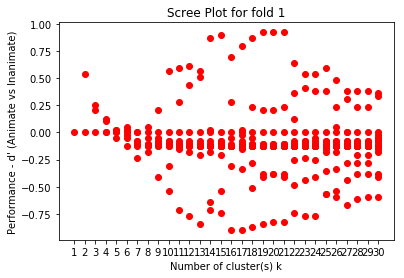

In [12]:
f = 1
clf_result = result[f]


plt.figure(1)
X = range(1,31,1)
for cl in X:
    i = 0
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'ro')
        i += 1
        
plt.xticks(X)
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Performance - d' (Animate vs Inanimate)")
plt.title('Scree Plot for fold '+ str(f))
plt.savefig('../../results/scree/results_fold_'+str(f)+'.svg', format='svg', dpi=1200)

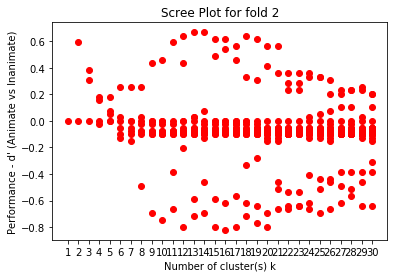

In [13]:
f = 2
clf_result = result[f]


plt.figure(1)
X = range(1,31,1)
for cl in X:
    i = 0
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'ro')
        i += 1
        
plt.xticks(X)
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Performance - d' (Animate vs Inanimate)")
plt.title('Scree Plot for fold '+ str(f))
plt.savefig('../../results/scree/results_fold_'+str(f)+'.svg', format='svg', dpi=1200)

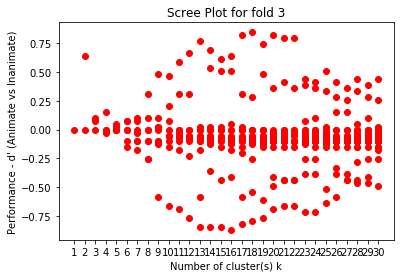

In [14]:
f = 3
clf_result = result[f]


plt.figure(1)
X = range(1,31,1)
for cl in X:
    i = 0
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'ro')
        i += 1
        
plt.xticks(X)
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Performance - d' (Animate vs Inanimate)")
plt.title('Scree Plot for fold '+ str(f))
plt.savefig('../../results/scree/results_fold_'+str(f)+'.svg', format='svg', dpi=1200)

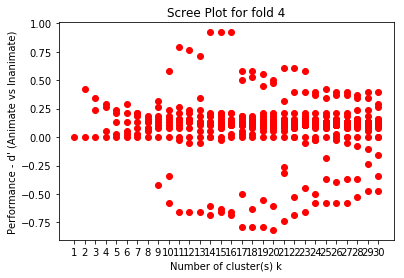

In [15]:
f = 4
clf_result = result[f]


plt.figure(1)
X = range(1,31,1)
for cl in X:
    i = 0
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'ro')
        i += 1
        
plt.xticks(X)
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Performance - d' (Animate vs Inanimate)")
plt.title('Scree Plot for fold '+ str(f))
plt.savefig('../../results/scree/results_fold_'+str(f)+'.svg', format='svg', dpi=1200)

In [18]:
#Loading the pickle files
k = 4
result ={}
for i in range(1,k+1,1):
    name = '../../data/pkl/30_scree_fold_'+str(i)+'.pickle'   #CHANGE
    with open(name,"rb") as f:
        result[i] = pickle.load(f)

In [19]:
result

{1: {1: {0: 0.0},
  2: {0: 0.0, 1: 0.5384615384615384},
  3: {0: 0.0, 1: 0.20512820512820518, 2: 0.2564102564102564},
  4: {0: 0.0, 1: 0.10256410256410253, 2: 0.1282051282051282, 3: 0.0},
  5: {0: 0.0,
   1: 0.0,
   2: -0.05128205128205132,
   3: 0.02564102564102566,
   4: 0.02564102564102555},
  6: {0: 0.0,
   1: -0.05128205128205132,
   2: -0.02564102564102566,
   3: 0.05128205128205132,
   4: -0.1282051282051282,
   5: 0.02564102564102566},
  7: {0: 0.0,
   1: -0.10256410256410264,
   2: -0.07692307692307698,
   3: -0.1282051282051282,
   4: -0.07692307692307687,
   5: 0.0,
   6: -0.23076923076923073},
  8: {0: -0.17948717948717952,
   1: -0.10256410256410253,
   2: -0.1282051282051282,
   3: 0.0,
   4: -0.1282051282051282,
   5: 0.05128205128205121,
   6: -0.05128205128205121,
   7: -0.10256410256410253},
  9: {0: -0.07692307692307698,
   1: 0.0,
   2: -0.41025641025641024,
   3: -0.1282051282051282,
   4: 0.20512820512820507,
   5: -0.1282051282051282,
   6: -0.10256410256410253,


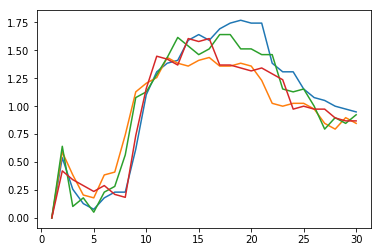

In [20]:
#Find MaxAd', MaxId' and its average
plt.figure()
noc = 4
for i in range(1,noc+1,1):
    X = []
    Y = []
    for j in range(1,31,1):
        X.append(j)
        temp = []
        for key, value in result[i][j].iteritems():
            temp.append(value)
        maxa = max(temp)
        maxi = min(temp)
        avg = float(maxa - maxi)
        Y.append(avg)
    #print X,Y
    plt.plot(X,Y)

0.959008097166 14


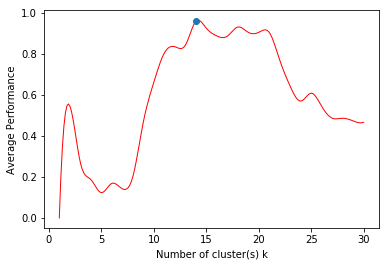

In [21]:
#Smooth average graph

noc = 4
flag = 0
X = range(1,31,1)
an_fold =[]
ian_fold = []
Y = []
for i in range(1,noc+1,1):
    if i == 2:
        flag = 1
    for j in range(1,31,1):
        temp = []
        for key, value in result[i][j].iteritems():
            temp.append(value)
        maxa = max(temp)
        maxi = min(temp)
        if flag == 0:
            an_fold.append(maxa)
            ian_fold.append(maxi)
        else:
            an_fold[j-1] += maxa
            ian_fold[j-1] = maxi

for j in range(1,31,1):
    maxa = (an_fold[j-1]) / 4.
    maxi = (ian_fold[j-1]) /4.
    diff = maxa - maxi
    Y.append(diff)
    
x_sm = np.array(X)
y_sm = np.array(Y)

x_smooth = np.linspace(x_sm.min(), x_sm.max(), 200)
y_smooth = spline(X, Y, x_smooth)

plt.plot(x_smooth, y_smooth, 'r', linewidth=1)
plt.plot(Y.index(max(Y))+1,max(Y),'o')
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Average Performance")

print max(Y), Y.index(max(Y)) + 1